In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/fedavg-main

/content/drive/MyDrive/fedavg-main


In [3]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [4]:
# setting random seeds
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

In [5]:
# hyperparams
bsz = 10

In [6]:
# setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are currently using this device:", device)

We are currently using this device: cuda


60000


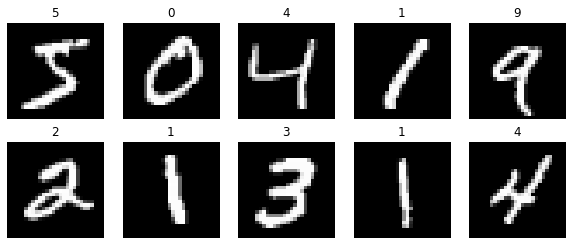

In [15]:
train_data, test_data = fetch_dataset()
print(len(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [26]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)


iid:  tensor([64., 65., 59., 61., 63., 54., 54., 63., 53., 64.])


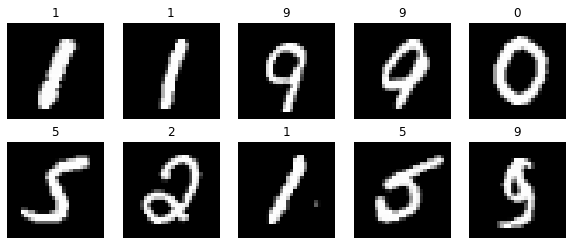

In [28]:
# iid
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)

non-iid:  tensor([  0.,   0., 600.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])


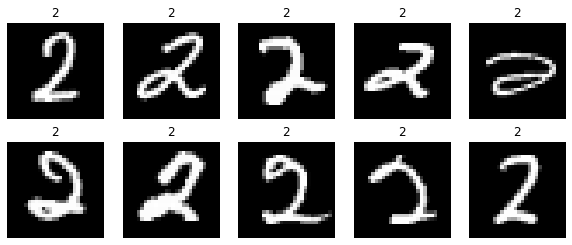

In [29]:
# non-iid
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[10]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)

In [30]:
def num_params(model):
    """ """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [31]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # [B x 784]
        x = F.relu(self.fc1(x)) # [B x 200]
        x = F.relu(self.fc2(x)) # [B x 200]
        x = self.out(x) # [B x 10]
        return x

print(MLP())
print(num_params(MLP()))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
199210


In [32]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())
print(num_params(CNN()))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
582026


In [ ]:
## Training

In [33]:
criterion = nn.CrossEntropyLoss()
def validate(model):
    model = model.to(cuda)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to(cuda)
            y = y.to(cuda)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [36]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(cuda)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(cuda)
            y = y.to(cuda)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(cpu)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)
        
        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)


In [ ]:
 ## MLP experiments


In [37]:
mlp = MLP()
print(mlp)
print("total params: ", num_params(mlp))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
total params:  199210


In [ ]:
# MLP - iid - m=10 (number of clients per round) experiment
cpu='cpu'
cuda='cuda'
mlp_iid_m10 = copy.deepcopy(mlp)
acc_mlp_iid_m10 = fed_avg_experiment(mlp_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='/content/drive/MyDrive/fedavg-main/acc_mlp_iid_m10')
print(acc_mlp_iid_m10)
np.save('./acc_mlp_iid_m10.npy', acc_mlp_iid_m10)


In [ ]:
# MLP - iid - m=50 (number of clients per round) experiment
mlp_iid_m50 = copy.deepcopy(mlp)
acc_mlp_iid_m50 = fed_avg_experiment(mlp_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m50')
print(acc_mlp_iid_m50)
np.save('./acc_mlp_iid_m50.npy', acc_mlp_iid_m50)

In [ ]:
# MLP - non-iid - m=10 experiment
mlp_noniid_m10 = copy.deepcopy(mlp)
acc_mlp_noniid_m10 = fed_avg_experiment(mlp_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename = './acc_mlp_noniid_m10')
print(acc_mlp_noniid_m10)
np.save('./acc_mlp_noniid_m10.npy', acc_mlp_noniid_m10)


In [ ]:
# MLP - noniid - m=50 experiment
mlp_noniid_m50 = copy.deepcopy(mlp)
acc_mlp_noniid_m50 = fed_avg_experiment(mlp_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_mlp_noniid_m50')
print(acc_mlp_noniid_m50)
np.save('./acc_mlp_noniid_m50.npy', acc_mlp_noniid_m50)


In [ ]:
## CNN Experiments


In [43]:
cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))
cpu='cpu'
cuda='cuda'


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
total params:  582026


In [ ]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m10')



In [ ]:
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

In [ ]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)


In [ ]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)


In [ ]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)


In [49]:
import numpy as np
import matplotlib.pyplot as plt
# acc-> accuracy mlp/cnn iid/non idd all vector fecthed and ploted

In [50]:
acc_mlp_iid_m10 = np.load('/content/drive/MyDrive/fedavg-main/acc_mlp_iid_m10.npy')
acc_mlp_iid_m50 = np.load('/content/drive/MyDrive/fedavg-main/acc_mlp_iid_m50.npy')
acc_cnn_iid_m10 = np.load('/content/drive/MyDrive/fedavg-main/acc_cnn_iid_m10.npy')
acc_cnn_iid_m50 = np.load('/content/drive/MyDrive/fedavg-main/acc_cnn_iid_m50.npy')


In [51]:
#non iid
acc_mlp_noniid_m10 = np.load('/content/drive/MyDrive/fedavg-main/acc_mlp_noniid_m10.npy')
acc_mlp_noniid_m50 = np.load('/content/drive/MyDrive/fedavg-main/acc_mlp_noniid_m50.npy')
acc_cnn_noniid_m10 = np.load('/content/drive/MyDrive/fedavg-main/acc_cnn_noniid_m10.npy')
acc_cnn_noniid_m50 = np.load('/content/drive/MyDrive/fedavg-main/acc_cnn_noniid_m50.npy')

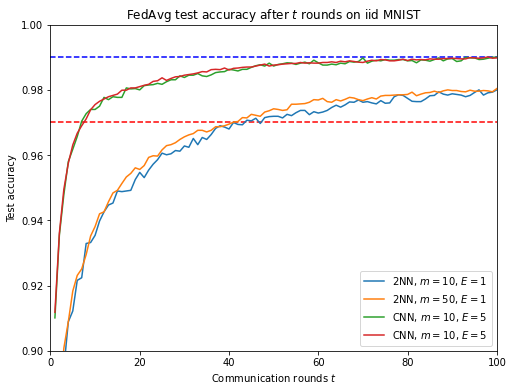

In [52]:
x = np.arange(1,101)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after $t$ rounds on iid MNIST")
plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 100, 0.9, 1])
plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')

plt.plot(x, acc_mlp_iid_m10, label='2NN, $m=10$, $E=1$')
plt.plot(x, acc_mlp_iid_m50, label='2NN, $m=50$, $E=1$')
plt.plot(x, acc_cnn_iid_m10, label='CNN, $m=10$, $E=5$')
plt.plot(x, acc_cnn_iid_m50, label='CNN, $m=10$, $E=5$')
#plt.plot(np.arange(1,52), acc_cnn_iid_m50, label='CNN, $m=50$, $E=5$')

plt.legend()

plt.show()

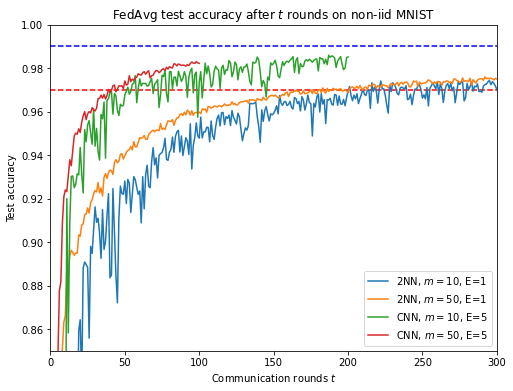

In [53]:
x = np.arange(1,301)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after $t$ rounds on non-iid MNIST")
plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 300, 0.85, 1])
plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')
plt.plot(x, acc_mlp_noniid_m10[:300], label='2NN, $m=10$, E=1')
plt.plot(x, acc_mlp_noniid_m50, label='2NN, $m=50$, E=1')
plt.plot(x[:200], acc_cnn_noniid_m10, label='CNN, $m=10$, E=5')
plt.plot(x[:100], acc_cnn_noniid_m50, label='CNN, $m=50$, E=5')
plt.legend()
plt.show()